In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset, concatenate_datasets, Dataset

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import numpy as np
import pandas as pd 

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

import tqdm

import evaluate 

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay


In [22]:
def get_artifical_data_for_label(label:str):
    label_dict = {
        "rrms": "relapsing_remitting_multiple_sclerosis",
        "ppms": "primary_progressive_multiple_sclerosis",
        "spms": "secondary_progressive_multiple_sclerosis"
    }
    generated_data = pd.read_csv(paths.DATA_PATH_PREPROCESSED/f'ms-diag/artificial_{label}.csv')
    generated_data["labels"] = label_dict[label]
    generated_data = generated_data[["0", "labels"]].rename(columns = {"0":"text"})

    return generated_data

def get_artifical_data_all():
    artifical_data = []
    for label in ["rrms", "ppms", "spms"]:
        try: 
            artifical_data.append(get_artifical_data_for_label(label))
        except:
            print(f"Could not find data for {label}")
    artifical_data = pd.concat(artifical_data)
    artifical_data = Dataset.from_pandas(artifical_data).remove_columns('__index_level_0__')
    return artifical_data
artifical_data = []

In [23]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
df["train"] = concatenate_datasets([get_artifical_data_all(), df["train"]])

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {'primary_progressive_multiple_sclerosis': 0,
            'relapsing_remitting_multiple_sclerosis': 1,
            'secondary_progressive_multiple_sclerosis': 2}
id2label = {v:k for k,v in label2id.items()}

Could not find data for rrms


In [24]:
# # Run this cell if you want to download and fine-tune the model
# from huggingface_hub import notebook_login

# # Login to Hugging Face Hub as model is gated
# notebook_login()

# # Checkpoint
# checkpoint = "GerMedBERT/medbert-512"

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# # Save tokenizer
# tokenizer.save_pretrained(paths.MODEL_PATH/'medbert')

# # Load model for embedding
# model = AutoModel.from_pretrained(checkpoint)

# # Save model
# model.save_pretrained(paths.MODEL_PATH/'medbert')

In [25]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def prepare_data(data):
    
    # Label
    data['labels'] = [label2id[label] for label in data['labels']]

    # Tokenize
    # data["text"] = [text[:256] for text in data["text"]]
    data = tokenizer(data['text'], padding=True, truncation=True, return_tensors='pt', max_length = 256)

    return data

# Tokenize dataset
dataset = df.map(prepare_data, batched=True, remove_columns=['rid', 'text', 'date'], batch_size=512)

In [27]:
# Training arguments
EPOCHS = 12
BATCH_SIZE = 16
TRAIN_STEPS = EPOCHS * len(dataset['train']) // BATCH_SIZE

# Collator
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

# Dataloader
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Accelerator
accelerator = Accelerator(mixed_precision='fp16')

# Optimizer and scheduler
optim = AdamW(model.parameters(), lr=1e-4)
lr_scheduler = get_scheduler(
    "linear",
    optim,
    num_warmup_steps=0,
    num_training_steps=TRAIN_STEPS
)

# Prepare with accelerator
model, optim, train_loader, val_loader, test_loader = accelerator.prepare(
    model, optim, train_loader, val_loader, test_loader
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [28]:
# Training
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
progress_bar = tqdm.tqdm(range(TRAIN_STEPS))

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        optim.step()
        lr_scheduler.step()
        progress_bar.update(1)

    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        val_loss = 0
        acc = 0
        for batch in val_loader:
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            
            val_loss += outputs.loss
            acc += (predictions == batch['labels']).sum().item()
            
            preds.extend(predictions.tolist())
            labels.extend(batch['labels'].tolist())

    f1 = f1_score(labels, preds, average='macro')
    if epoch == 0:
            min_val_loss = val_loss
            largest_f1 = f1
    elif (epoch > 3) & (val_loss < min_val_loss):
        min_val_loss = val_loss
        model.save_pretrained(paths.MODEL_PATH/'ms_diag_medbert_valloss')
    elif (epoch > 3) & (largest_f1 < f1):
        largest_f1 = f1
        model.save_pretrained(paths.MODEL_PATH/'ms_diag_medbert_f1')

    print(f"Epoch {epoch+1}: F1 score: {f1} Loss: {val_loss/len(val_loader)} Accuracy: {acc/len(dataset['validation'])}")


288it [02:05,  2.29it/s]00:00<?, ?it/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.

  9%|▊         | 25/287 [00:03<00:36,  7.11it/s]

Epoch 1: F1 score: 0.30769230769230765 Loss: 0.5312107801437378 Accuracy: 0.8571428571428571



 17%|█▋        | 49/287 [00:06<00:34,  6.94it/s]

Epoch 2: F1 score: 0.30769230769230765 Loss: 0.630799412727356 Accuracy: 0.8571428571428571



 25%|██▌       | 73/287 [00:09<00:30,  7.09it/s]

Epoch 3: F1 score: 0.6533333333333333 Loss: 0.3763735592365265 Accuracy: 0.9285714285714286



 34%|███▍      | 97/287 [00:12<00:26,  7.09it/s]

Epoch 4: F1 score: 0.6533333333333333 Loss: 0.2975933849811554 Accuracy: 0.9285714285714286



 42%|████▏     | 121/287 [00:16<01:05,  2.52it/s]

Epoch 5: F1 score: 0.32 Loss: 0.6541276574134827 Accuracy: 0.8571428571428571



 51%|█████     | 145/287 [00:20<00:20,  7.09it/s]

Epoch 6: F1 score: 0.32 Loss: 0.651219367980957 Accuracy: 0.8571428571428571



 59%|█████▉    | 169/287 [00:23<00:16,  7.06it/s]

Epoch 7: F1 score: 0.32 Loss: 0.6652919054031372 Accuracy: 0.8571428571428571



 67%|██████▋   | 193/287 [00:27<00:35,  2.61it/s]

Epoch 8: F1 score: 0.6533333333333333 Loss: 0.38120657205581665 Accuracy: 0.9285714285714286



 76%|███████▌  | 217/287 [00:31<00:27,  2.58it/s]

Epoch 9: F1 score: 0.6533333333333333 Loss: 0.3927749991416931 Accuracy: 0.9285714285714286



 84%|████████▍ | 241/287 [00:34<00:06,  7.07it/s]

Epoch 10: F1 score: 0.6533333333333333 Loss: 0.4009776711463928 Accuracy: 0.9285714285714286



 92%|█████████▏| 265/287 [00:37<00:03,  7.05it/s]

Epoch 11: F1 score: 0.6533333333333333 Loss: 0.4016144573688507 Accuracy: 0.9285714285714286



100%|██████████| 287/287 [00:40<00:00,  7.54it/s]
288it [00:40,  7.72it/s]                         

Epoch 12: F1 score: 0.6533333333333333 Loss: 0.4023922383785248 Accuracy: 0.9285714285714286


In [29]:
# torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'ms_diag_medbert_valloss', num_labels=num_labels).to(accelerator.device)
# Predictions
predictions = []
labels = []
#f1_test = evaluate.load("f1")
for batch in tqdm.tqdm(test_loader):
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        #f1_test.add_batch(predictions=preds, references=batch['labels'])
        predictions.extend(preds.tolist())
        labels.extend(batch['labels'].tolist())

#f1_score = f1_test.compute(average='weighted')
#print("F1", f1_score)

100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


F1 Score: 0.9101307189542484
Precision: 0.8666666666666667
Recall: 0.9871794871794872


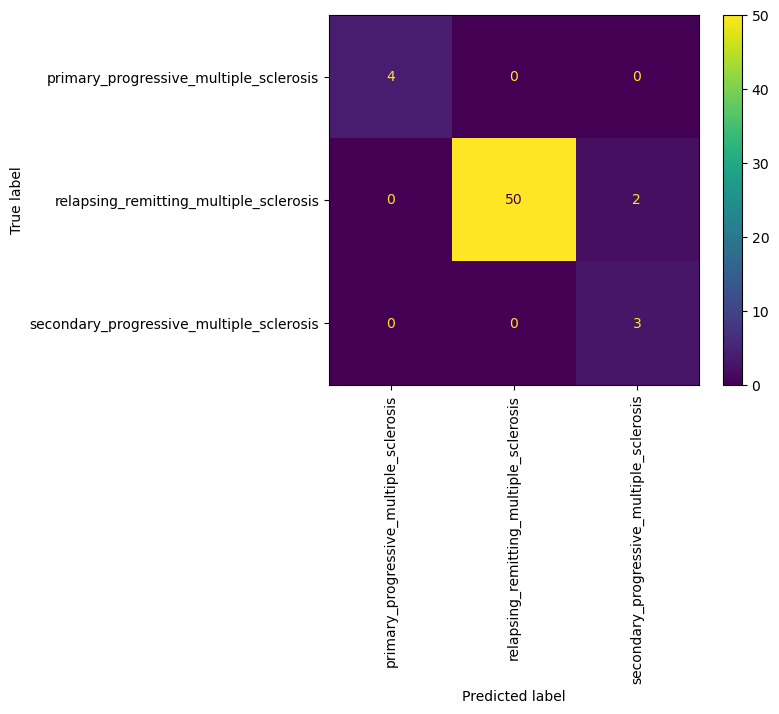

In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels, predictions, average='macro')}")
print(f"Precision: {precision_score(labels, predictions, average='macro')}")
print(f"Recall: {recall_score(labels, predictions, average='macro')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=list(id2label.values()), xticks_rotation='vertical')

pd.DataFrame({"labels": labels, "predictions": predictions}).to_csv(paths.RESULTS_PATH/"ms-diag"/"ms-diag_medbert-finetuned-artif.csv", index=False)

In [31]:
import pandas as pd
df_test = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag/ms-diag_clean_test.csv'))
for i, label in enumerate(labels):
    if label != predictions[i]:
        print("Entry: ", i)
        print("Label", id2label[label])
        print("Predicted", id2label[predictions[i]])
        print("Text: ", df_test.iloc[i]["text"])
        print("\n")

Entry:  3
Label relapsing_remitting_multiple_sclerosis
Predicted secondary_progressive_multiple_sclerosis
Text:  Schubförmige Multiple Sklerose mit V. a. sekundär chronisch progredienten Verlauf seit ca. 2016, EM 1997, ED 2003, EDSS 6.0 klinisch: nicht aktiv; radiologisch: nicht aktiv; Progression: nein (Lublin, 2013) aktuell: spastische ataktische Gangstörung beinbetont rechts, distal- und beinbetontes motorisches Hemisyndrom rechts, 6Min Gehtest 460m Verlauf:  INDENT 05/ 1997 1.Schub mit beidseitiger Visusminderung, vollständige Rückbildung INDENT 2003 - 2007 alle 1.5 - 2 Jahre ein Schub (motorische Störung der Beine), starke Depression  INDENT 2007 - 2014 mehrere Schübe unter Copaxone (Schubrate nicht bekannt)  INDENT 09/2014: Schub mit Gangunsicherheit und Parese des rechten Beines, Koordinationsstörungen der rechten Hand (inkomplette Regression der Parese des rechten Beines)  INDENT 11/2016 Progression der Steifigkeit und Ermüdbarkeit der rechten Bein in Vergleich zu vergangenen J

F1 Score: 0.9836206678311941
Precision: 0.9868421052631579
Recall: 0.9824561403508771


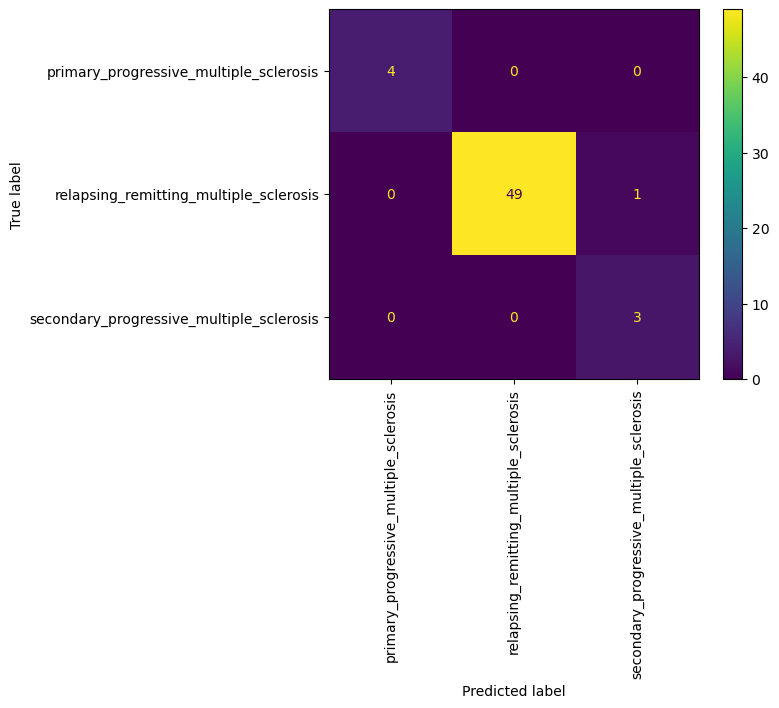

In [32]:
# Entry 3 is both RRMS and SPMS (so correct classification) and entry 56 is not MS
# Entries to be removed
entries_to_remove = [3, 56]

# Create a new list without the specified entries
predictions_corrected = [x for i, x in enumerate(predictions) if i not in entries_to_remove]
labels_corrected = [x for i, x in enumerate(labels) if i not in entries_to_remove]

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels_corrected, predictions_corrected, average='weighted')}")
print(f"Precision: {precision_score(labels_corrected, predictions_corrected, average='weighted')}")
print(f"Recall: {recall_score(labels_corrected, predictions_corrected, average='weighted')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels_corrected, predictions_corrected, display_labels=list(id2label.values()), xticks_rotation='vertical')